# Predicción de Brotes de Dengue usando Redes Neuronales Recurrentes (RNN)

## Introducción

Este proyecto implementa una solución completa para predecir brotes futuros de dengue en diferentes barrios utilizando técnicas avanzadas de Deep Learning y análisis de series temporales. Utilizaremos:

- **Darts**: Librería especializada en series temporales
- **PyTorch**: Framework de Deep Learning para implementar RNN
- **Optuna**: Optimización bayesiana de hiperparámetros

## Estructura del Proyecto

1. **Análisis Exploratorio**: Entendimiento profundo de los datos temporales
2. **Preprocesamiento**: Preparación específica para series temporales  
3. **Modelos Baseline**: Implementación con Darts
4. **RNN Personalizada**: Arquitectura desde cero con PyTorch
5. **Optimización**: Búsqueda de hiperparámetros con Optuna
6. **Predicciones Finales**: Generación de resultados

# Sección 1: Importación de Librerías y Configuración

In [32]:
#%pip uninstall torch torchvision torchaudio

In [33]:
#%pip install darts
#%pip install optuna
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [34]:
# Librerías fundamentales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

# PyTorch y componentes de Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Darts para series temporales (importaciones compatibles)
try:
    from darts import TimeSeries
    from darts.models import (
        ARIMA, LinearRegressionModel, RandomForest
    )
    # Intentar importar Prophet
    try:
        from darts.models import Prophet
        PROPHET_AVAILABLE = True
    except ImportError:
        print("⚠️  Prophet no disponible en esta instalación de Darts")
        PROPHET_AVAILABLE = False
    
    # Intentar importar modelos de Deep Learning
    try:
        from darts.models import RNNModel
        RNN_DARTS_AVAILABLE = True
    except ImportError:
        print("⚠️  RNNModel no disponible en esta instalación de Darts")
        RNN_DARTS_AVAILABLE = False
    
    try:
        from darts.models import BlockRNNModel
        BLOCK_RNN_AVAILABLE = True
    except ImportError:
        BLOCK_RNN_AVAILABLE = False
    
    from darts.metrics import mape, mae, rmse
    
    # Utilidades de Darts
    try:
        from darts.utils.timeseries_generation import datetime_attribute_timeseries
        from darts.dataprocessing.transformers import Scaler
        from darts.utils.model_selection import train_test_split
        DARTS_UTILS_AVAILABLE = True
    except ImportError:
        print("⚠️  Algunas utilidades de Darts no están disponibles")
        DARTS_UTILS_AVAILABLE = False
    
    DARTS_AVAILABLE = True
    print("✅ Darts importado exitosamente")
    
except ImportError as e:
    print(f"❌ Error importando Darts: {e}")
    print("💡 Instalación sugerida: pip install darts")
    DARTS_AVAILABLE = False
    PROPHET_AVAILABLE = False
    RNN_DARTS_AVAILABLE = False
    BLOCK_RNN_AVAILABLE = False
    DARTS_UTILS_AVAILABLE = False

# Optuna para optimización
try:
    import optuna
    from optuna.visualization import (
        plot_optimization_history, plot_param_importances,
        plot_slice, plot_contour
    )
    OPTUNA_AVAILABLE = True
    print("✅ Optuna importado exitosamente")
except ImportError:
    print("⚠️  Optuna no disponible. Instalación: pip install optuna")
    OPTUNA_AVAILABLE = False

# Análisis estadístico y preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_regression

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tsa.seasonal import STL
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    STATSMODELS_AVAILABLE = True
    print("✅ Statsmodels importado exitosamente")
except ImportError:
    print("⚠️  Statsmodels no completamente disponible")
    STATSMODELS_AVAILABLE = False

# Interpretabilidad (opcional)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️  SHAP no disponible. Instalación: pip install shap")
    SHAP_AVAILABLE = False

# Utilidades
import logging
import os
from datetime import datetime, timedelta
import pickle
import json
from typing import Tuple, List, Dict, Optional

# Configuración de reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Usando dispositivo: {device}")

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Mostrar estado de dependencias
print("\n📦 ESTADO DE DEPENDENCIAS:")
print("=" * 40)
print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Pandas: {pd.__version__}")
print(f"✅ NumPy: {np.__version__}")
print(f"✅ Matplotlib: {plt.matplotlib.__version__}")
print(f"{'✅' if DARTS_AVAILABLE else '❌'} Darts: {'Disponible' if DARTS_AVAILABLE else 'No disponible'}")
print(f"{'✅' if OPTUNA_AVAILABLE else '❌'} Optuna: {'Disponible' if OPTUNA_AVAILABLE else 'No disponible'}")
print(f"{'✅' if STATSMODELS_AVAILABLE else '❌'} Statsmodels: {'Disponible' if STATSMODELS_AVAILABLE else 'No disponible'}")
print(f"{'✅' if SHAP_AVAILABLE else '❌'} SHAP: {'Disponible' if SHAP_AVAILABLE else 'No disponible'}")

if not DARTS_AVAILABLE:
    print("\n💡 NOTA IMPORTANTE:")
    print("Darts no está disponible. Las secciones 6 requerirán instalación:")
    print("pip install darts")
    print("Alternativamente, esas secciones se pueden omitir.")

if not OPTUNA_AVAILABLE:
    print("\n💡 NOTA IMPORTANTE:")
    print("Optuna no está disponible. La sección 9 requerirá instalación:")
    print("pip install optuna")
    print("Alternativamente, se puede usar grid search manual.")

✅ Darts importado exitosamente
✅ Optuna importado exitosamente
✅ Statsmodels importado exitosamente
🖥️  Usando dispositivo: cuda

📦 ESTADO DE DEPENDENCIAS:
✅ PyTorch: 2.7.1+cu118
✅ Pandas: 2.2.3
✅ NumPy: 2.2.6
✅ Matplotlib: 3.10.3
✅ Darts: Disponible
✅ Optuna: Disponible
✅ Statsmodels: Disponible
✅ SHAP: Disponible


# Sección 2: Carga y Exploración Inicial de Datos

In [35]:
def load_and_explore_data():
    """
    Carga los datos y realiza exploración inicial
    """
    # Cargar datos
    print("🔄 Cargando datos...")
    df_train = pd.read_parquet('../../Datos/df_train.parquet')
    df_test = pd.read_parquet('../../Datos/df_test.parquet')
    sample_submission = pd.read_csv('../../Datos/sample_submission.csv')
    
    print("✅ Datos cargados exitosamente\n")
    
    # Información básica de entrenamiento
    print("📊 DATOS DE ENTRENAMIENTO")
    print("=" * 50)
    print(f"Shape: {df_train.shape}")
    print(f"Período: {df_train['anio'].min()}-{df_train['anio'].max()}")
    print(f"Semanas: {df_train['semana'].min()}-{df_train['semana'].max()}")
    print(f"Barrios únicos: {df_train['id_bar'].nunique()}")
    
    print("\nColumnas y tipos de datos:")
    print(df_train.dtypes)
    
    print("\nValores faltantes:")
    missing_train = df_train.isnull().sum()
    print(missing_train[missing_train > 0])
    
    # Información básica de test
    print("\n📊 DATOS DE TEST")
    print("=" * 50)
    print(f"Shape: {df_test.shape}")
    print(f"Período: {df_test['anio'].min()}-{df_test['anio'].max()}")
    print(f"Semanas: {df_test['semana'].min()}-{df_test['semana'].max()}")
    print(f"Barrios únicos: {df_test['id_bar'].nunique()}")
    
    # Descripción estadística
    print("\n📈 ESTADÍSTICAS DESCRIPTIVAS - ENTRENAMIENTO")
    print("=" * 60)
    print(df_train.describe())
    
    # Distribución de la variable target
    print("\n🎯 ANÁLISIS DE VARIABLE TARGET 'DENGUE'")
    print("=" * 50)
    dengue_stats = df_train['dengue'].describe()
    print(dengue_stats)
    
    print(f"\nValores únicos de dengue: {df_train['dengue'].nunique()}")
    print(f"Ceros en dengue: {(df_train['dengue'] == 0).sum()} ({(df_train['dengue'] == 0).mean()*100:.1f}%)")
    print(f"Valores > 10: {(df_train['dengue'] > 10).sum()} ({(df_train['dengue'] > 10).mean()*100:.1f}%)")
    
    return df_train, df_test, sample_submission

# Ejecutar carga y exploración
df_train, df_test, sample_submission = load_and_explore_data()

🔄 Cargando datos...
✅ Datos cargados exitosamente

📊 DATOS DE ENTRENAMIENTO
Shape: (3680, 20)
Período: 2015-2021
Semanas: 1-53
Barrios únicos: 10

Columnas y tipos de datos:
id                   object
id_bar                int64
anio                  int64
semana               UInt32
ESTRATO             float64
area_barrio         float64
dengue              float64
concentraciones     float64
vivienda            float64
equipesado          float64
sumideros           float64
maquina             float64
lluvia_mean         float64
lluvia_var          float64
lluvia_max          float64
lluvia_min          float64
temperatura_mean    float64
temperatura_var     float64
temperatura_max     float64
temperatura_min     float64
dtype: object

Valores faltantes:
Series([], dtype: int64)

📊 DATOS DE TEST
Shape: (520, 19)
Período: 2022-2022
Semanas: 1-52
Barrios únicos: 10

📈 ESTADÍSTICAS DESCRIPTIVAS - ENTRENAMIENTO
            id_bar         anio     semana      ESTRATO  area_barrio  \
coun

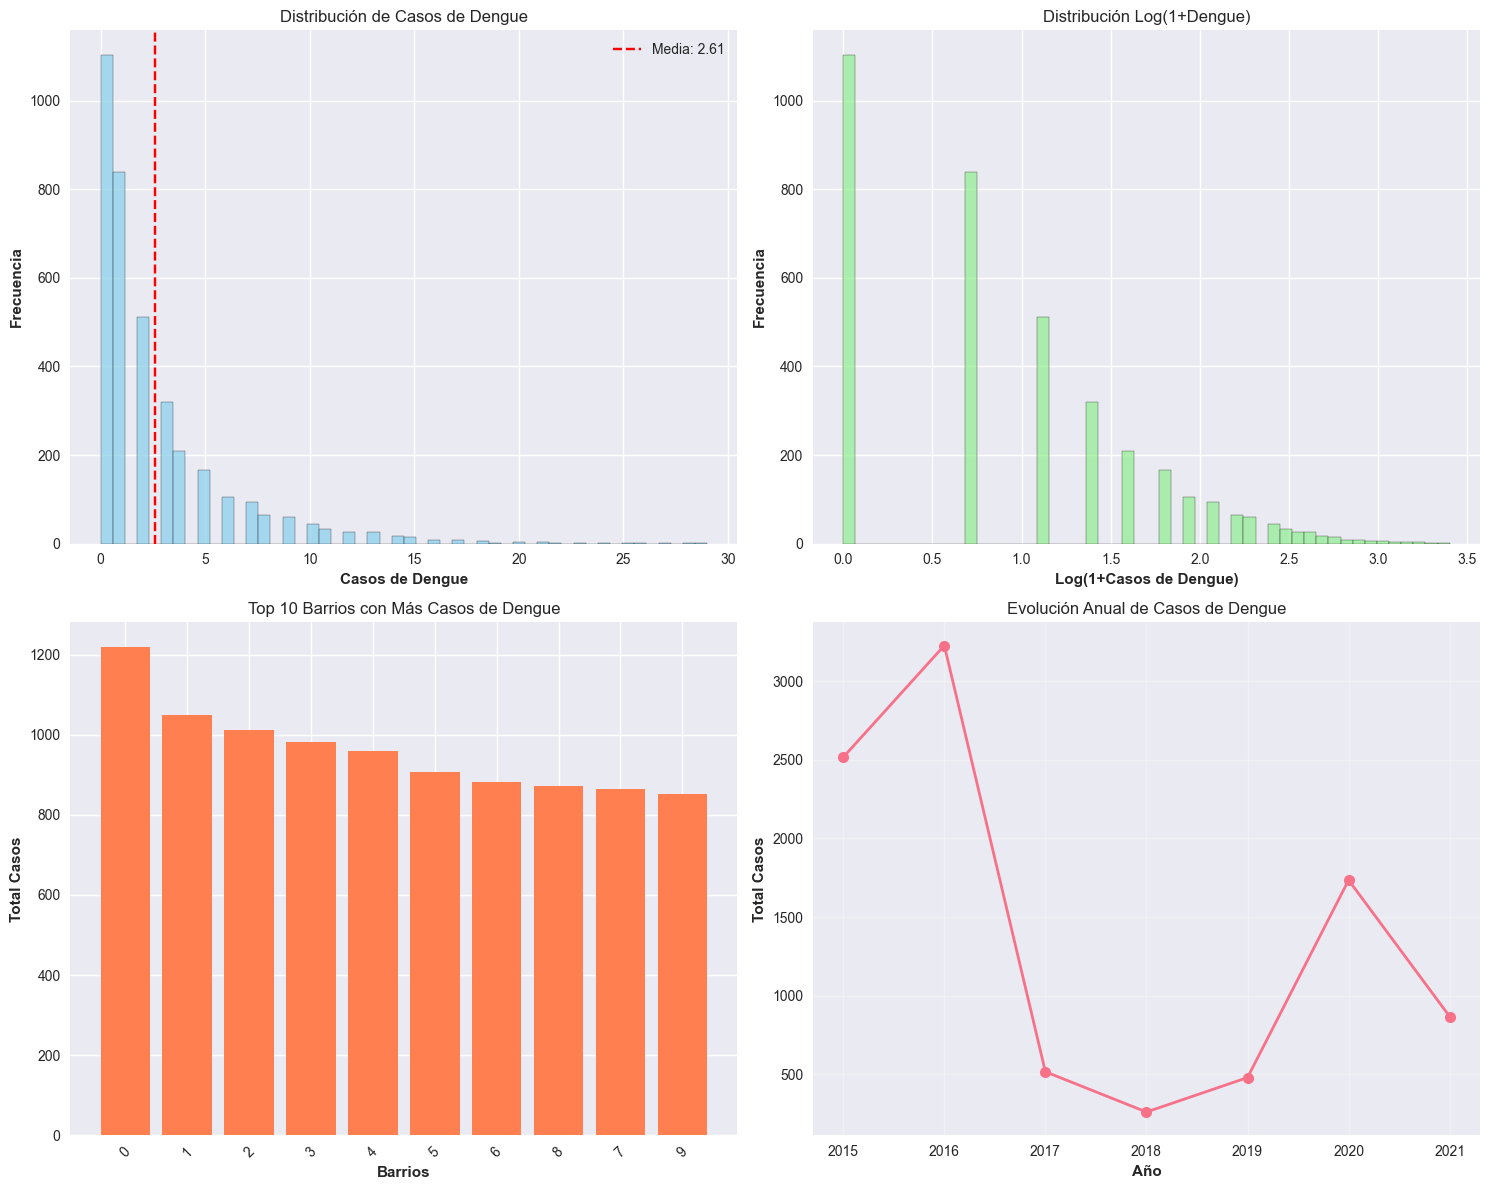

📋 INFORMACIÓN ADICIONAL
Total de casos de dengue en el período: 9,603
Promedio de casos por semana: 2.61
Barrio con más casos: 0 (1220 casos)
Año con más casos: 2016 (3226 casos)


In [36]:
def visualize_initial_exploration(df_train):
    """
    Visualizaciones iniciales de exploración
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distribución de dengue
    axes[0,0].hist(df_train['dengue'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribución de Casos de Dengue')
    axes[0,0].set_xlabel('Casos de Dengue')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].axvline(df_train['dengue'].mean(), color='red', linestyle='--', 
                     label=f'Media: {df_train["dengue"].mean():.2f}')
    axes[0,0].legend()
    
    # Log-distribución (para ver mejor los valores bajos)
    log_dengue = np.log1p(df_train['dengue'])
    axes[0,1].hist(log_dengue, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Distribución Log(1+Dengue)')
    axes[0,1].set_xlabel('Log(1+Casos de Dengue)')
    axes[0,1].set_ylabel('Frecuencia')
    
    # Casos por barrio
    dengue_by_barrio = df_train.groupby('id_bar')['dengue'].sum().sort_values(ascending=False)
    top_10_barrios = dengue_by_barrio.head(10)
    axes[1,0].bar(range(len(top_10_barrios)), top_10_barrios.values, color='coral')
    axes[1,0].set_title('Top 10 Barrios con Más Casos de Dengue')
    axes[1,0].set_xlabel('Barrios')
    axes[1,0].set_ylabel('Total Casos')
    axes[1,0].set_xticks(range(len(top_10_barrios)))
    axes[1,0].set_xticklabels(top_10_barrios.index, rotation=45)
    
    # Casos por año
    dengue_by_year = df_train.groupby('anio')['dengue'].sum()
    axes[1,1].plot(dengue_by_year.index, dengue_by_year.values, marker='o', linewidth=2, markersize=8)
    axes[1,1].set_title('Evolución Anual de Casos de Dengue')
    axes[1,1].set_xlabel('Año')
    axes[1,1].set_ylabel('Total Casos')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Información adicional
    print("📋 INFORMACIÓN ADICIONAL")
    print("=" * 40)
    print(f"Total de casos de dengue en el período: {df_train['dengue'].sum():,.0f}")
    print(f"Promedio de casos por semana: {df_train['dengue'].mean():.2f}")
    print(f"Barrio con más casos: {dengue_by_barrio.index[0]} ({dengue_by_barrio.iloc[0]:.0f} casos)")
    print(f"Año con más casos: {dengue_by_year.idxmax()} ({dengue_by_year.max():.0f} casos)")

# Ejecutar visualizaciones iniciales
visualize_initial_exploration(df_train)

# Sección 3: Análisis Temporal Exploratorio

🕒 ANÁLISIS DE PATRONES TEMPORALES
Usando período estacional: 52 (datos: 364 observaciones)
⚠️  Error en descomposición STL: seasonal must be an odd positive integer >= 3
Usando análisis temporal alternativo...


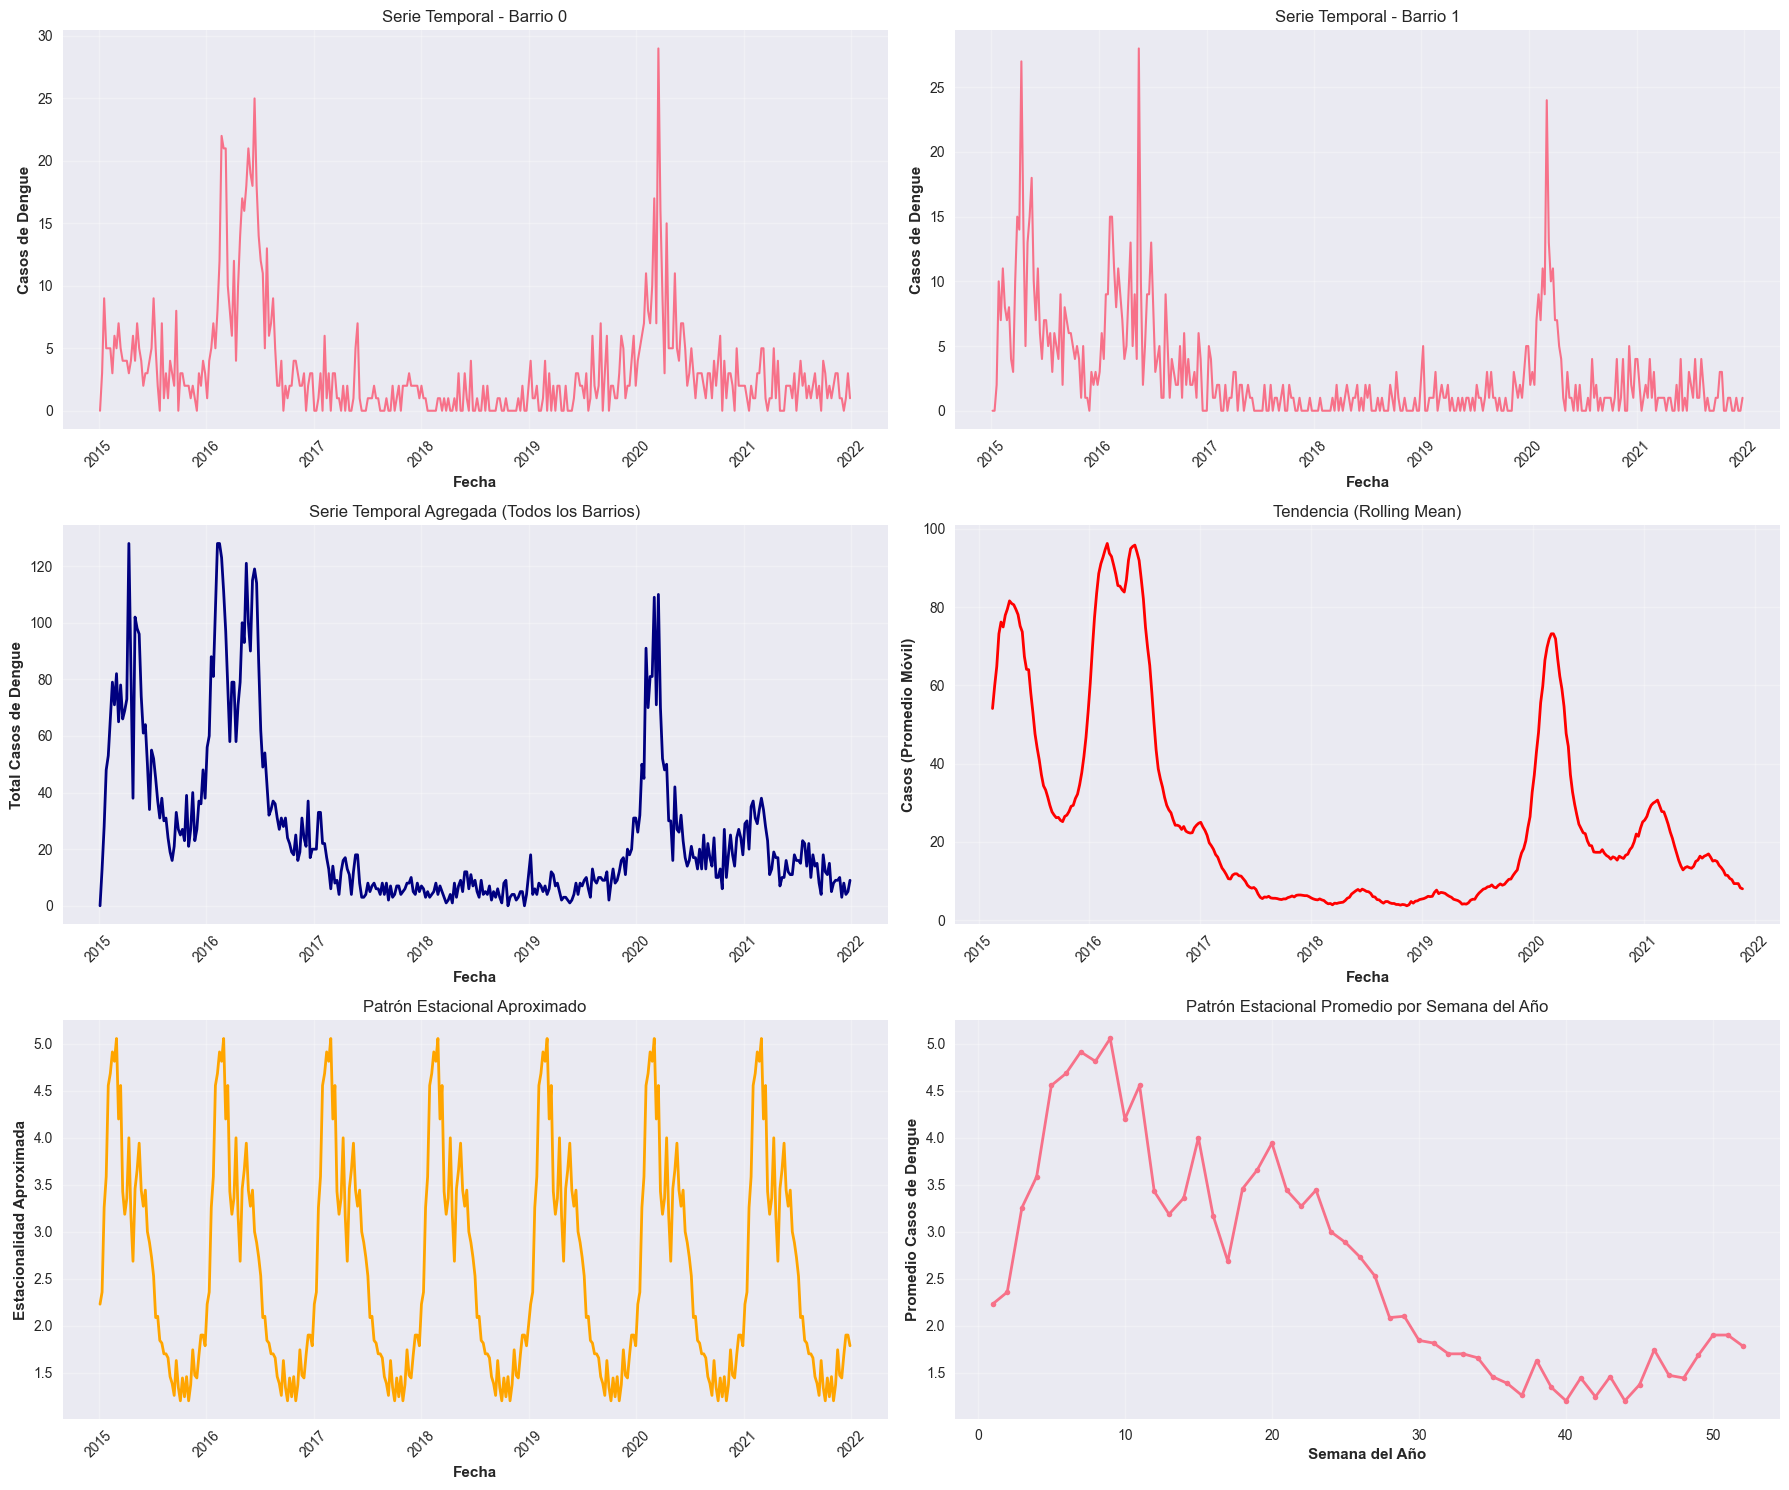


📊 ANÁLISIS DE AUTOCORRELACIÓN


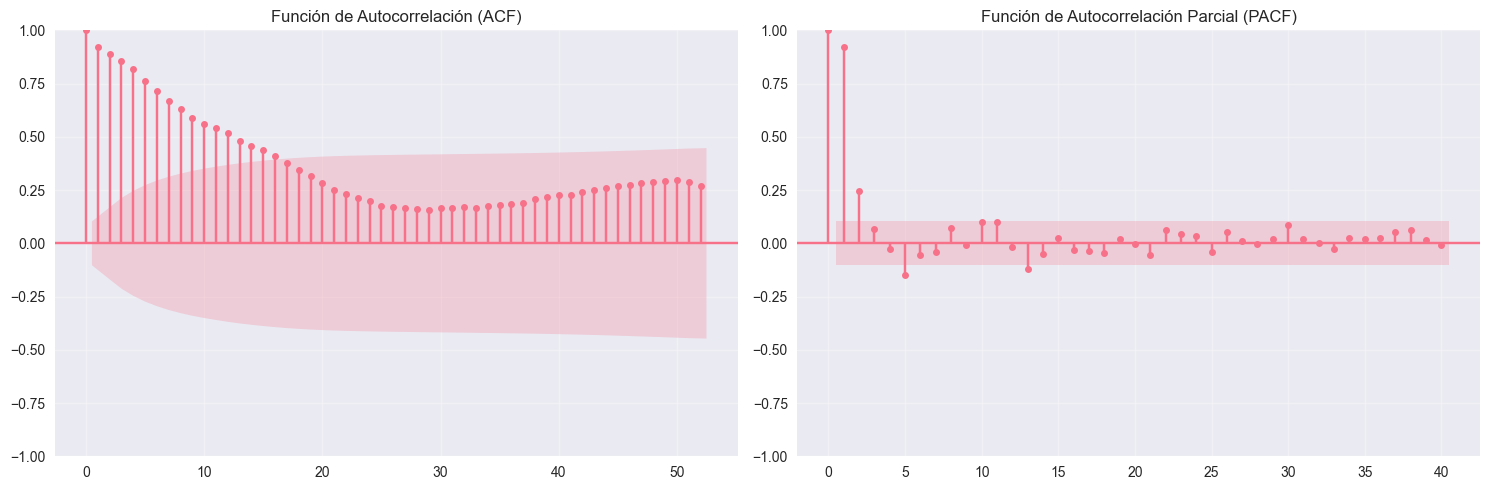

Lags con autocorrelación significativa (>0.1): [ 1  2  3  4  5  6  7  8  9 10]
Autocorrelación en lag 1: 0.924
Autocorrelación en lag 52 (anual): 0.272

Estadísticas de la serie:
  Longitud: 364 observaciones
  Media: 26.20
  Desviación estándar: 28.51
  Coeficiente de variación: 108.9%

Test de Estacionaridad (ADF):
  Estadístico ADF: -2.9405
  p-valor: 0.0408
  Resultado: Estacionaria (α=0.05)


In [37]:
def prepare_temporal_data(df_train):
    """
    Prepara los datos para análisis temporal
    """
    # Crear fecha a partir de año y semana
    df_temporal = df_train.copy()
    
    # Convertir año y semana a fecha de manera más robusta
    def year_week_to_date(row):
        try:
            # Crear fecha del primer día de la semana
            year = int(row['anio'])
            week = int(row['semana'])
            
            # Asegurar que la semana esté en rango válido
            week = max(1, min(week, 52))
            
            # Crear fecha usando el primer día del año y añadir semanas
            base_date = pd.Timestamp(year=year, month=1, day=1)
            # Ajustar al lunes de la primera semana
            days_to_monday = (7 - base_date.weekday()) % 7
            first_monday = base_date + pd.Timedelta(days=days_to_monday)
            # Añadir semanas
            target_date = first_monday + pd.Timedelta(weeks=week-1)
            
            return target_date
        except:
            # Fallback: usar año y semana directamente
            return pd.Timestamp(f"{row['anio']}-01-01") + pd.Timedelta(weeks=row['semana']-1)
    
    df_temporal['fecha'] = df_temporal.apply(year_week_to_date, axis=1)
    
    # Ordenar por fecha y barrio
    df_temporal = df_temporal.sort_values(['id_bar', 'fecha'])
    
    # Eliminar posibles duplicados por barrio y fecha
    df_temporal = df_temporal.drop_duplicates(subset=['id_bar', 'fecha'], keep='first')
    
    return df_temporal

def analyze_temporal_patterns(df_temporal):
    """
    Análisis detallado de patrones temporales
    """
    print("🕒 ANÁLISIS DE PATRONES TEMPORALES")
    print("=" * 50)
    
    # Seleccionar algunos barrios representativos para análisis detallado
    top_barrios = df_temporal.groupby('id_bar')['dengue'].sum().nlargest(5).index
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    
    # 1. Series temporales por barrio principal
    for i, barrio in enumerate(top_barrios):
        if i >= 2: break
        data_barrio = df_temporal[df_temporal['id_bar'] == barrio]
        axes[0, i].plot(data_barrio['fecha'], data_barrio['dengue'], linewidth=1.5)
        axes[0, i].set_title(f'Serie Temporal - Barrio {barrio}')
        axes[0, i].set_xlabel('Fecha')
        axes[0, i].set_ylabel('Casos de Dengue')
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].tick_params(axis='x', rotation=45)
    
    # 2. Análisis estacional agregado
    df_agregado = df_temporal.groupby(['fecha'])['dengue'].sum().reset_index()
    axes[1, 0].plot(df_agregado['fecha'], df_agregado['dengue'], linewidth=2, color='navy')
    axes[1, 0].set_title('Serie Temporal Agregada (Todos los Barrios)')
    axes[1, 0].set_xlabel('Fecha')
    axes[1, 0].set_ylabel('Total Casos de Dengue')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 3. Descomposición STL del agregado (con manejo de errores)
    try:
        ts_agregado = df_agregado.set_index('fecha')['dengue']
        
        # Asegurar frecuencia regular
        ts_agregado = ts_agregado.asfreq('W', method='pad')  # Frecuencia semanal
        
        # Calcular período estacional apropiado
        n_obs = len(ts_agregado)
        if n_obs >= 104:  # Al menos 2 años de datos
            seasonal_period = 52  # Anual
        elif n_obs >= 52:  # Al menos 1 año
            seasonal_period = 52
        elif n_obs >= 26:  # Al menos medio año
            seasonal_period = 26
        else:
            seasonal_period = min(13, n_obs // 3)  # Trimestral o menos
        
        print(f"Usando período estacional: {seasonal_period} (datos: {n_obs} observaciones)")
        
        # Solo proceder si tenemos suficientes datos
        if n_obs >= seasonal_period * 2 and seasonal_period >= 3:
            stl = STL(ts_agregado, seasonal=seasonal_period, robust=True)
            decomposition = stl.fit()
            
            axes[1, 1].plot(decomposition.trend, label='Tendencia', linewidth=2)
            axes[1, 1].set_title('Tendencia de la Serie Agregada')
            axes[1, 1].set_xlabel('Fecha')
            axes[1, 1].set_ylabel('Casos (Tendencia)')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].tick_params(axis='x', rotation=45)
            
            # 4. Componente estacional
            axes[2, 0].plot(decomposition.seasonal, color='orange', linewidth=2)
            axes[2, 0].set_title('Componente Estacional')
            axes[2, 0].set_xlabel('Fecha')
            axes[2, 0].set_ylabel('Estacionalidad')
            axes[2, 0].grid(True, alpha=0.3)
            axes[2, 0].tick_params(axis='x', rotation=45)
        else:
            # Fallback: mostrar tendencia simple con rolling mean
            rolling_trend = ts_agregado.rolling(window=min(12, len(ts_agregado)//3), center=True).mean()
            axes[1, 1].plot(ts_agregado.index, rolling_trend, label='Tendencia (Rolling)', linewidth=2)
            axes[1, 1].set_title('Tendencia Suavizada (Rolling Mean)')
            axes[1, 1].set_xlabel('Fecha')
            axes[1, 1].set_ylabel('Casos (Tendencia)')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].tick_params(axis='x', rotation=45)
            
            # Crear decomposition falsa para compatibilidad
            decomposition = type('obj', (object,), {
                'trend': rolling_trend,
                'seasonal': ts_agregado - rolling_trend,
                'resid': ts_agregado * 0  # Residuos cero
            })
            
            axes[2, 0].plot(decomposition.seasonal, color='orange', linewidth=2)
            axes[2, 0].set_title('Componente Estacional (Aproximado)')
            axes[2, 0].set_xlabel('Fecha')
            axes[2, 0].set_ylabel('Estacionalidad')
            axes[2, 0].grid(True, alpha=0.3)
            axes[2, 0].tick_params(axis='x', rotation=45)
            
            print("⚠️  Usando descomposición simplificada debido a datos limitados")
            
    except Exception as e:
        print(f"⚠️  Error en descomposición STL: {e}")
        print("Usando análisis temporal alternativo...")
        
        # Fallback: análisis simple sin descomposición
        ts_agregado = df_agregado.set_index('fecha')['dengue']
        
        # Tendencia con rolling mean
        window_size = min(12, len(ts_agregado)//3, len(ts_agregado))
        if window_size >= 3:
            rolling_mean = ts_agregado.rolling(window=window_size, center=True).mean()
            axes[1, 1].plot(ts_agregado.index, rolling_mean, linewidth=2, color='red')
            axes[1, 1].set_title('Tendencia (Rolling Mean)')
            axes[1, 1].set_xlabel('Fecha')
            axes[1, 1].set_ylabel('Casos (Promedio Móvil)')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Variabilidad estacional aproximada
        if 'semana' in df_temporal.columns:
            seasonal_approx = df_temporal.groupby('semana')['dengue'].mean()
            # Expandir a toda la serie temporal
            df_temporal['seasonal_approx'] = df_temporal['semana'].map(seasonal_approx)
            seasonal_series = df_temporal.groupby('fecha')['seasonal_approx'].first()
            
            axes[2, 0].plot(seasonal_series.index, seasonal_series.values, color='orange', linewidth=2)
            axes[2, 0].set_title('Patrón Estacional Aproximado')
            axes[2, 0].set_xlabel('Fecha')
            axes[2, 0].set_ylabel('Estacionalidad Aproximada')
            axes[2, 0].grid(True, alpha=0.3)
            axes[2, 0].tick_params(axis='x', rotation=45)
        
        # Crear objeto decomposition simple para compatibilidad
        decomposition = type('obj', (object,), {
            'trend': rolling_mean if 'rolling_mean' in locals() else ts_agregado,
            'seasonal': seasonal_series if 'seasonal_series' in locals() else ts_agregado * 0,
            'resid': ts_agregado * 0
        })
    
    # 5. Análisis por semana del año
    df_temporal['semana_año'] = df_temporal['semana']
    seasonal_pattern = df_temporal.groupby('semana_año')['dengue'].mean()
    axes[2, 1].plot(seasonal_pattern.index, seasonal_pattern.values, 
                   marker='o', linewidth=2, markersize=4)
    axes[2, 1].set_title('Patrón Estacional Promedio por Semana del Año')
    axes[2, 1].set_xlabel('Semana del Año')
    axes[2, 1].set_ylabel('Promedio Casos de Dengue')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df_temporal, decomposition

def analyze_autocorrelation(df_temporal):
    """
    Análisis de autocorrelación
    """
    print("\n📊 ANÁLISIS DE AUTOCORRELACIÓN")
    print("=" * 40)
    
    # Preparar serie agregada
    df_agregado = df_temporal.groupby('fecha')['dengue'].sum()
    
    # Verificar que tenemos suficientes datos
    if len(df_agregado) < 20:
        print(f"⚠️  Muy pocos datos para análisis de autocorrelación ({len(df_agregado)} puntos)")
        print("Se requieren al menos 20 puntos temporales para un análisis robusto")
        return
    
    # Asegurar que no hay valores faltantes
    df_agregado = df_agregado.fillna(df_agregado.mean())
    
    # Determinar número de lags apropiado
    max_lags = min(52, len(df_agregado) // 3, 100)  # Máximo 52 semanas (1 año) o 1/3 de los datos
    
    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Autocorrelación
        plot_acf(df_agregado, lags=max_lags, ax=axes[0], alpha=0.05)
        axes[0].set_title('Función de Autocorrelación (ACF)')
        axes[0].grid(True, alpha=0.3)
        
        # Autocorrelación parcial
        plot_pacf(df_agregado, lags=min(max_lags, 40), ax=axes[1], alpha=0.05)  # PACF con menos lags
        axes[1].set_title('Función de Autocorrelación Parcial (PACF)')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas de autocorrelación
        from statsmodels.tsa.stattools import acf
        
        # Calcular autocorrelación con número apropiado de lags
        autocorr_lags = min(max_lags, len(df_agregado) - 1)
        autocorr = acf(df_agregado, nlags=autocorr_lags, fft=False)
        
        # Encontrar lags significativos
        # Usar umbral más conservador para series cortas
        threshold = 0.2 if len(df_agregado) < 100 else 0.1
        significant_lags = np.where(np.abs(autocorr[1:]) > threshold)[0] + 1
        
        print(f"Lags con autocorrelación significativa (>{threshold}): {significant_lags[:10]}")
        print(f"Autocorrelación en lag 1: {autocorr[1]:.3f}")
        
        # Autocorrelación anual (si tenemos suficientes datos)
        if len(autocorr) > 52:
            print(f"Autocorrelación en lag 52 (anual): {autocorr[52]:.3f}")
        elif len(autocorr) > 26:
            print(f"Autocorrelación en lag 26 (semestral): {autocorr[26]:.3f}")
        
        # Estadísticas adicionales
        print(f"\nEstadísticas de la serie:")
        print(f"  Longitud: {len(df_agregado)} observaciones")
        print(f"  Media: {df_agregado.mean():.2f}")
        print(f"  Desviación estándar: {df_agregado.std():.2f}")
        print(f"  Coeficiente de variación: {(df_agregado.std()/df_agregado.mean())*100:.1f}%")
        
        # Test de estacionaridad (Augmented Dickey-Fuller)
        try:
            from statsmodels.tsa.stattools import adfuller
            result = adfuller(df_agregado.dropna())
            print(f"\nTest de Estacionaridad (ADF):")
            print(f"  Estadístico ADF: {result[0]:.4f}")
            print(f"  p-valor: {result[1]:.4f}")
            print(f"  Resultado: {'Estacionaria' if result[1] < 0.05 else 'No estacionaria'} (α=0.05)")
        except Exception as e:
            print(f"⚠️  No se pudo realizar test de estacionaridad: {e}")
    
    except Exception as e:
        print(f"❌ Error en análisis de autocorrelación: {e}")
        print("Esto puede deberse a:")
        print("  - Datos insuficientes")
        print("  - Serie temporal irregular")
        print("  - Valores constantes en la serie")
        
        # Análisis alternativo simple
        try:
            print(f"\n📊 ANÁLISIS ALTERNATIVO:")
            print(f"  Correlación lag-1: {df_agregado.corr(df_agregado.shift(1)):.3f}")
            if len(df_agregado) > 7:
                print(f"  Correlación lag-7: {df_agregado.corr(df_agregado.shift(7)):.3f}")
        except:
            print("  No se pudo calcular correlaciones simples")

# Ejecutar análisis temporal
df_temporal = prepare_temporal_data(df_train)
df_temporal, decomposition = analyze_temporal_patterns(df_temporal)
analyze_autocorrelation(df_temporal)

# Sección 4: Análisis de Variables Predictoras

🔍 ANÁLISIS DE VARIABLES PREDICTORAS
Variables predictoras identificadas: 15
Variables: ['ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']


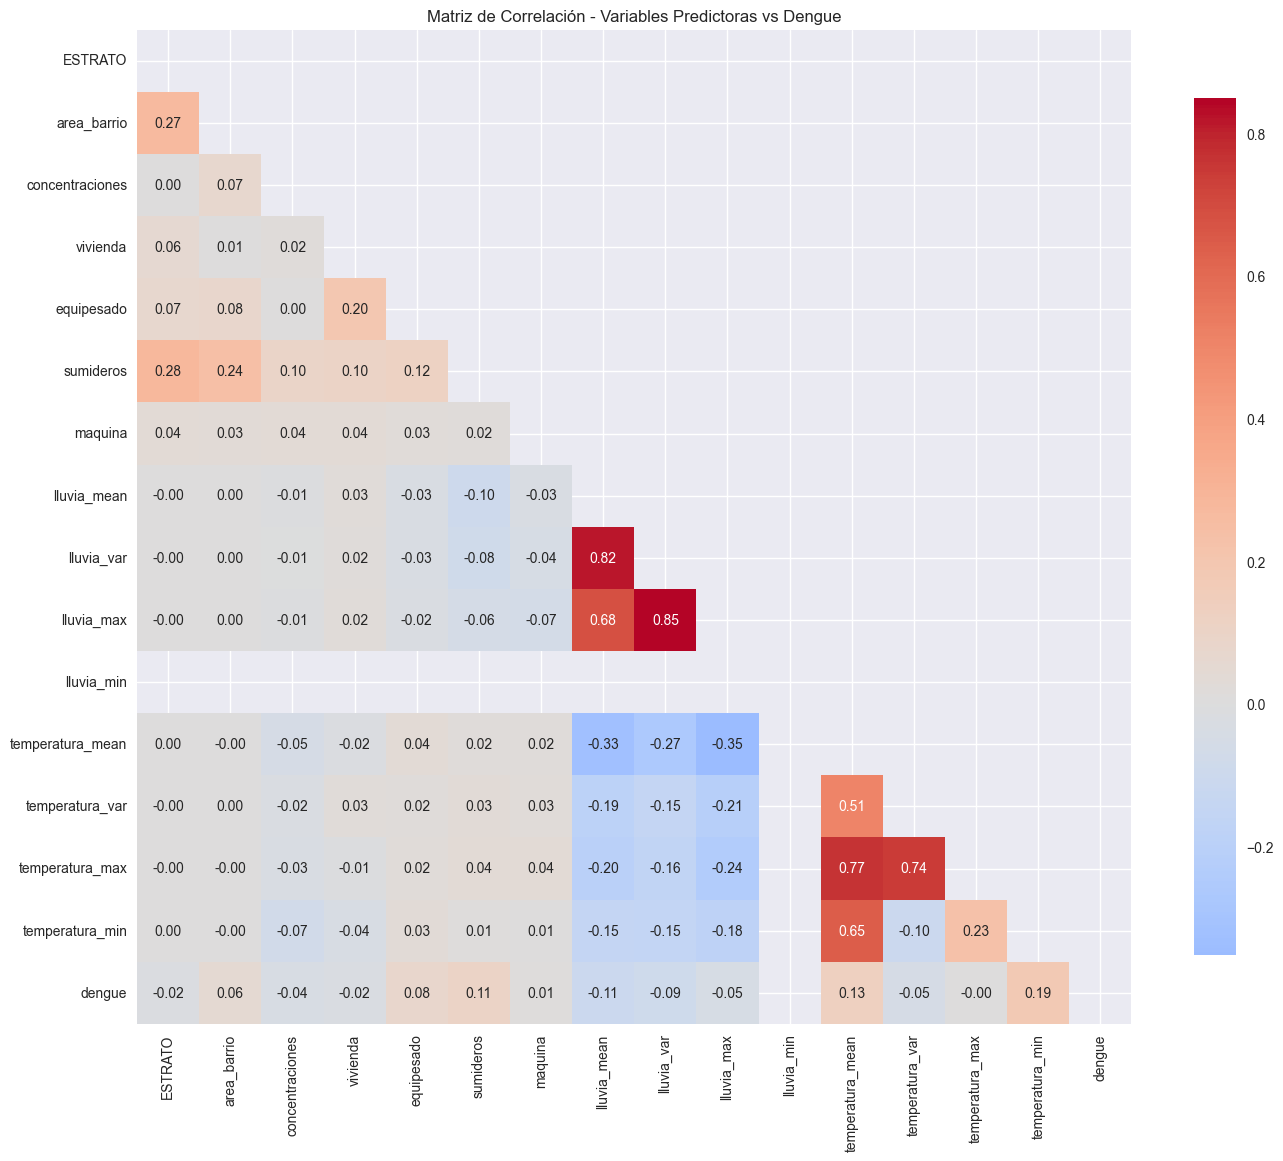


📈 CORRELACIONES CON DENGUE (ordenadas por magnitud):
------------------------------------------------------------
temperatura_min          :  0.186
temperatura_mean         :  0.128
lluvia_mean              : -0.108
sumideros                :  0.107
lluvia_var               : -0.088
equipesado               :  0.075
area_barrio              :  0.056
temperatura_var          : -0.048
lluvia_max               : -0.047
concentraciones          : -0.037
vivienda                 : -0.024
ESTRATO                  : -0.018
maquina                  :  0.012
temperatura_max          : -0.000
lluvia_min               :    nan


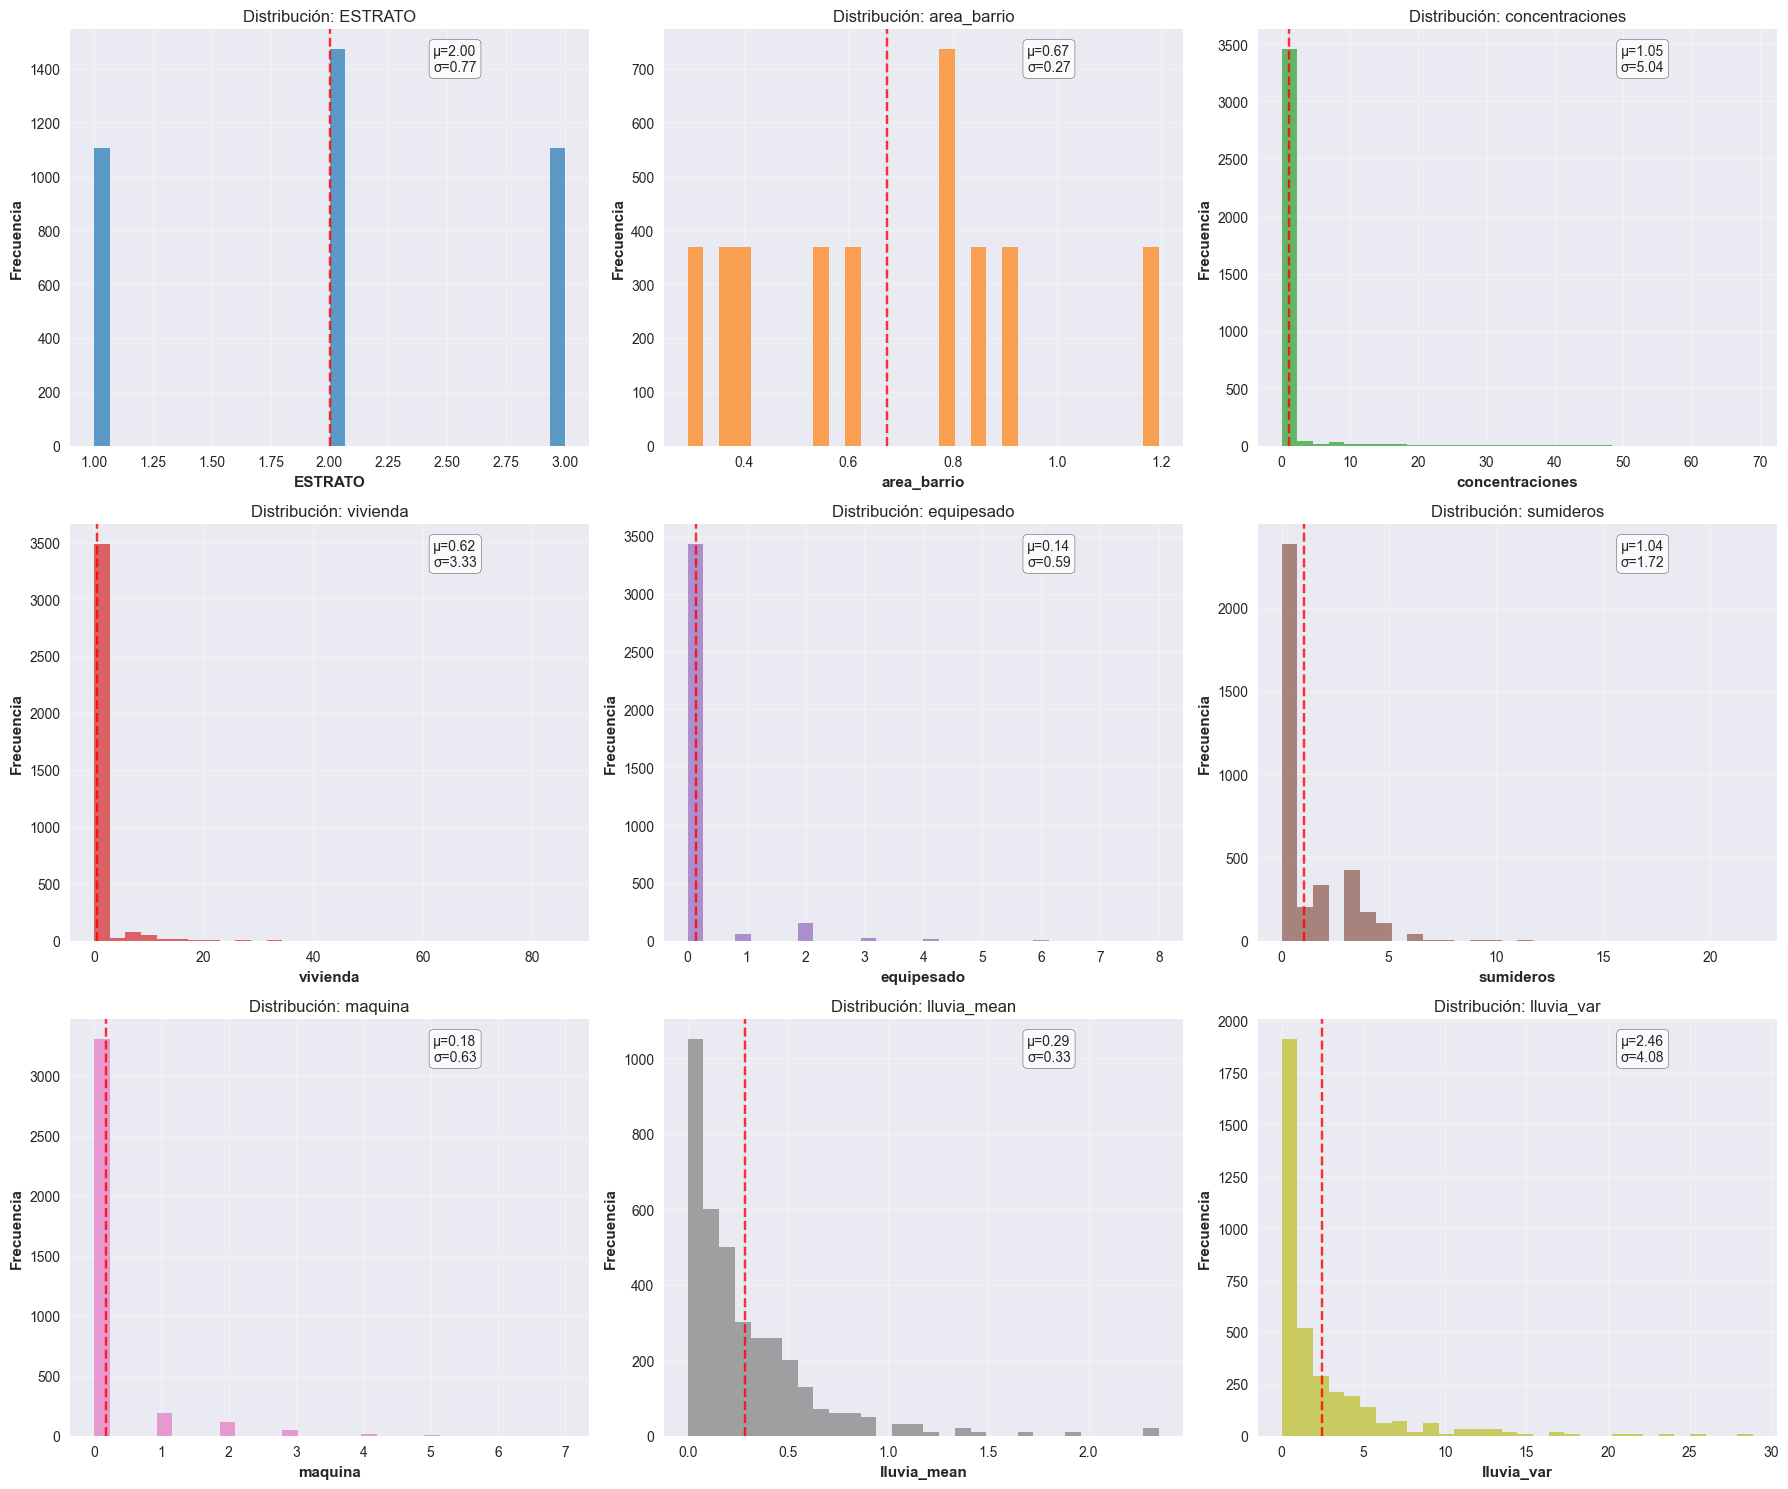


🔗 ANÁLISIS DE MULTICOLINEALIDAD (VIF)
Factor de Inflación de Varianza (VIF):
VIF > 10: Alta multicolinealidad
VIF > 5: Multicolinealidad moderada
----------------------------------------
temperatura_mean         :  3305.91 🔴 ALTA
temperatura_max          :  1655.41 🔴 ALTA
temperatura_min          :   892.24 🔴 ALTA
temperatura_var          :    56.89 🔴 ALTA
ESTRATO                  :     8.72 🟡 MODERADA
lluvia_max               :     8.47 🟡 MODERADA
area_barrio              :     8.25 🟡 MODERADA
lluvia_var               :     8.04 🟡 MODERADA
lluvia_mean              :     5.56 🟡 MODERADA
sumideros                :     1.59 🟢 BAJA
equipesado               :     1.12 🟢 BAJA
maquina                  :     1.10 🟢 BAJA
vivienda                 :     1.09 🟢 BAJA
concentraciones          :     1.07 🟢 BAJA
lluvia_min               :      nan 🟢 BAJA

⭐ ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
Importancia por Información Mutua:
----------------------------------------
temperatura_mean         

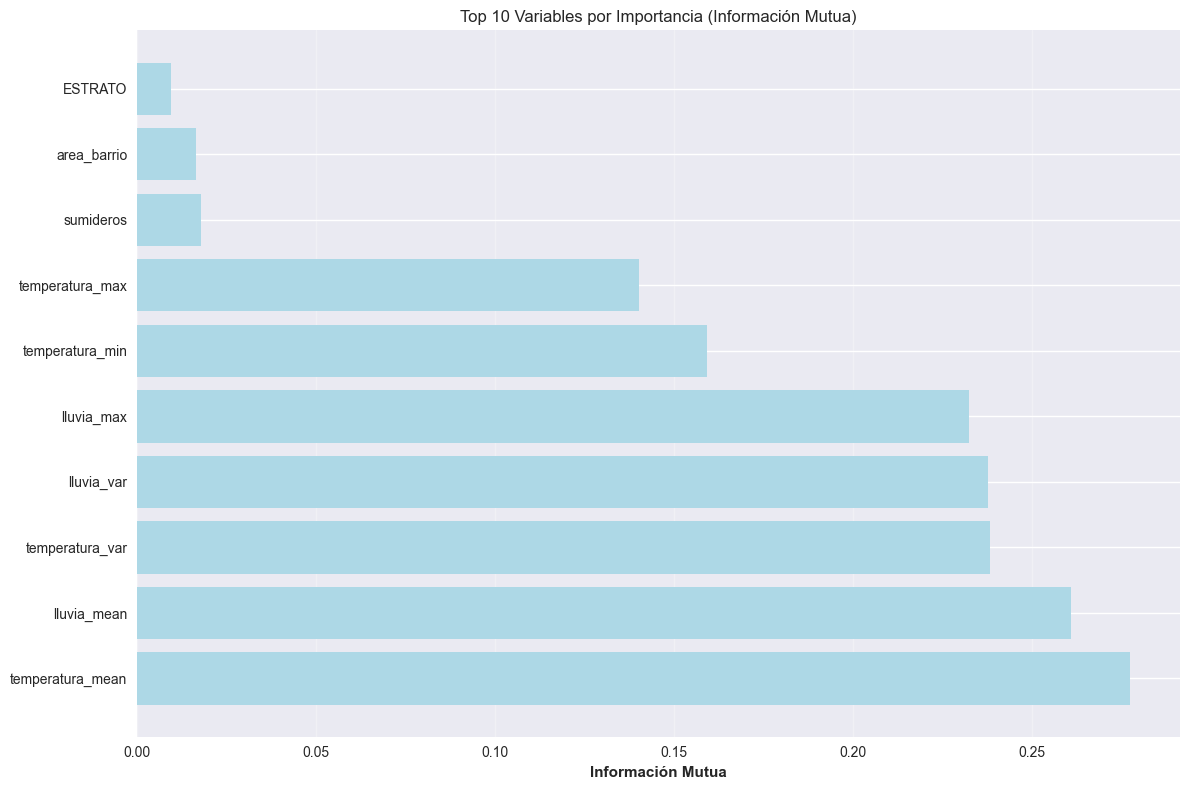

In [38]:
def analyze_predictive_variables(df_train):
    """
    Análisis profundo de variables predictoras
    """
    print("🔍 ANÁLISIS DE VARIABLES PREDICTORAS")
    print("=" * 50)
    
    # Variables numéricas (excluyendo id y target)
    numeric_vars = df_train.select_dtypes(include=[np.number]).columns.tolist()
    exclude_vars = ['id_bar', 'anio', 'semana', 'dengue', '__index_level_0__']
    predictive_vars = [var for var in numeric_vars if var not in exclude_vars]
    
    print(f"Variables predictoras identificadas: {len(predictive_vars)}")
    print(f"Variables: {predictive_vars}")
    
    # 1. Matriz de correlación
    correlation_matrix = df_train[predictive_vars + ['dengue']].corr()
    
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, fmt='.2f', square=True, cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlación - Variables Predictoras vs Dengue')
    plt.tight_layout()
    plt.show()
    
    # 2. Correlaciones con la variable target
    target_correlations = correlation_matrix['dengue'].drop('dengue').sort_values(key=abs, ascending=False)
    
    print("\n📈 CORRELACIONES CON DENGUE (ordenadas por magnitud):")
    print("-" * 60)
    for var, corr in target_correlations.items():
        print(f"{var:25}: {corr:6.3f}")
    
    # 3. Distribuciones de variables predictoras
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.ravel()
    
    for i, var in enumerate(predictive_vars[:9]):
        axes[i].hist(df_train[var].dropna(), bins=30, alpha=0.7, color=plt.cm.tab10(i))
        axes[i].set_title(f'Distribución: {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
        
        # Estadísticas básicas en el gráfico
        mean_val = df_train[var].mean()
        std_val = df_train[var].std()
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8)
        axes[i].text(0.7, 0.9, f'μ={mean_val:.2f}\nσ={std_val:.2f}', 
                    transform=axes[i].transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return predictive_vars, target_correlations

def analyze_multicollinearity(df_train, predictive_vars):
    """
    Análisis de multicolinealidad usando VIF
    """
    print("\n🔗 ANÁLISIS DE MULTICOLINEALIDAD (VIF)")
    print("=" * 50)
    
    # Preparar datos para VIF (eliminar NaN)
    df_vif = df_train[predictive_vars].dropna()
    
    # Calcular VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) 
                       for i in range(len(df_vif.columns))]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print("Factor de Inflación de Varianza (VIF):")
    print("VIF > 10: Alta multicolinealidad")
    print("VIF > 5: Multicolinealidad moderada")
    print("-" * 40)
    
    for _, row in vif_data.iterrows():
        status = "🔴 ALTA" if row['VIF'] > 10 else "🟡 MODERADA" if row['VIF'] > 5 else "🟢 BAJA"
        print(f"{row['Variable']:25}: {row['VIF']:8.2f} {status}")
    
    return vif_data

def feature_importance_analysis(df_train, predictive_vars):
    """
    Análisis de importancia de características
    """
    print("\n⭐ ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
    print("=" * 60)
    
    # Preparar datos
    X = df_train[predictive_vars].fillna(df_train[predictive_vars].median())
    y = df_train['dengue']
    
    # 1. Información mutua
    mi_scores = mutual_info_regression(X, y, random_state=RANDOM_SEED)
    mi_df = pd.DataFrame({
        'Variable': predictive_vars,
        'Mutual_Info': mi_scores
    }).sort_values('Mutual_Info', ascending=False)
    
    print("Importancia por Información Mutua:")
    print("-" * 40)
    for _, row in mi_df.head(10).iterrows():
        print(f"{row['Variable']:25}: {row['Mutual_Info']:8.4f}")
    
    # 2. Visualización de importancia
    plt.figure(figsize=(12, 8))
    top_features = mi_df.head(10)
    plt.barh(range(len(top_features)), top_features['Mutual_Info'], color='lightblue')
    plt.yticks(range(len(top_features)), top_features['Variable'])
    plt.xlabel('Información Mutua')
    plt.title('Top 10 Variables por Importancia (Información Mutua)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    return mi_df

# Ejecutar análisis de variables predictoras
predictive_vars, target_correlations = analyze_predictive_variables(df_train)
vif_data = analyze_multicollinearity(df_train, predictive_vars)
mi_df = feature_importance_analysis(df_train, predictive_vars)

# Sección 5: Preparación de Datos para Series Temporales

In [39]:
def create_temporal_features(df):
    """
    Crear características temporales adicionales
    """
    df_features = df.copy()
    
    # Crear fecha si no existe
    if 'fecha' not in df_features.columns:
        df_features['fecha'] = pd.to_datetime(
            df_features['anio'].astype(str) + '-W' + 
            df_features['semana'].astype(str).str.zfill(2) + '-1', 
            format='%Y-W%U-%w'
        )
    
    # Características temporales cíclicas
    df_features['semana_sin'] = np.sin(2 * np.pi * df_features['semana'] / 52)
    df_features['semana_cos'] = np.cos(2 * np.pi * df_features['semana'] / 52)
    
    # Mes (de la fecha)
    df_features['mes'] = df_features['fecha'].dt.month
    df_features['mes_sin'] = np.sin(2 * np.pi * df_features['mes'] / 12)
    df_features['mes_cos'] = np.cos(2 * np.pi * df_features['mes'] / 12)
    
    # Trimestre
    df_features['trimestre'] = df_features['fecha'].dt.quarter
    
    # Estación del año (hemisferio sur)
    def get_season_south(month):
        if month in [12, 1, 2]:
            return 'verano'
        elif month in [3, 4, 5]:
            return 'otoño'
        elif month in [6, 7, 8]:
            return 'invierno'
        else:
            return 'primavera'
    
    df_features['estacion'] = df_features['mes'].apply(get_season_south)
    
    # One-hot encoding para estación
    estacion_dummies = pd.get_dummies(df_features['estacion'], prefix='estacion')
    df_features = pd.concat([df_features, estacion_dummies], axis=1)
    
    return df_features

def create_lag_features(df, target_col='dengue', lags=[1, 2, 4, 8, 12, 24, 52]):
    """
    Crear características de lag y rolling windows
    """
    df_lag = df.copy()
    
    # Ordenar por barrio y fecha
    df_lag = df_lag.sort_values(['id_bar', 'fecha'])
    
    for barrio in df_lag['id_bar'].unique():
        mask = df_lag['id_bar'] == barrio
        barrio_data = df_lag.loc[mask, target_col]
        
        # Lags
        for lag in lags:
            df_lag.loc[mask, f'{target_col}_lag_{lag}'] = barrio_data.shift(lag)
        
        # Rolling means
        for window in [4, 8, 12, 24]:  # 4, 8, 12, 24 semanas
            df_lag.loc[mask, f'{target_col}_rolling_mean_{window}'] = (
                barrio_data.rolling(window=window, min_periods=1).mean()
            )
            df_lag.loc[mask, f'{target_col}_rolling_std_{window}'] = (
                barrio_data.rolling(window=window, min_periods=1).std()
            )
        
        # Diferencias
        df_lag.loc[mask, f'{target_col}_diff_1'] = barrio_data.diff(1)
        df_lag.loc[mask, f'{target_col}_diff_52'] = barrio_data.diff(52)  # Diferencia anual
    
    return df_lag

def prepare_data_for_modeling(df_train, df_test, predictive_vars):
    """
    Preparación completa de datos para modelado
    """
    print("🔧 PREPARACIÓN DE DATOS PARA MODELADO")
    print("=" * 50)
    
    # Crear características temporales
    print("Creando características temporales...")
    df_train_features = create_temporal_features(df_train)
    df_test_features = create_temporal_features(df_test)
    
    # Crear características de lag (solo para train ya que test no tiene target)
    print("Creando características de lag...")
    df_train_lag = create_lag_features(df_train_features)
    
    # Variables para el modelo
    temporal_features = ['semana_sin', 'semana_cos', 'mes_sin', 'mes_cos', 'trimestre']
    seasonal_features = ['estacion_verano', 'estacion_otoño', 'estacion_invierno', 'estacion_primavera']
    lag_features = [col for col in df_train_lag.columns if 'lag_' in col or 'rolling_' in col or 'diff_' in col]
    
    all_features = predictive_vars + temporal_features + seasonal_features + lag_features
    
    # Filtrar características que existen en ambos datasets
    available_features = [feat for feat in all_features if feat in df_train_lag.columns]
    
    print(f"Características disponibles: {len(available_features)}")
    print(f"Características temporales: {len(temporal_features)}")
    print(f"Características estacionales: {len(seasonal_features)}")
    print(f"Características de lag: {len(lag_features)}")
    
    # Preparar datos finales
    X_train = df_train_lag[available_features].copy()
    y_train = df_train_lag['dengue'].copy()
    X_test = df_test_features[available_features].copy() if all(feat in df_test_features.columns for feat in available_features) else None
    
    # Manejo de valores faltantes
    print(f"\nValores faltantes en X_train: {X_train.isnull().sum().sum()}")
    
    # Rellenar valores faltantes con estrategia apropiada
    # Para variables numéricas: mediana
    # Para lag features: forward fill por barrio
    for col in X_train.columns:
        if 'lag_' in col or 'rolling_' in col or 'diff_' in col:
            # Forward fill por barrio para características temporales
            for barrio in df_train_lag['id_bar'].unique():
                mask = df_train_lag['id_bar'] == barrio
                if mask.sum() > 0:
                    X_train.loc[mask, col] = X_train.loc[mask, col].fillna(method='ffill')
                    X_train.loc[mask, col] = X_train.loc[mask, col].fillna(0)  # Primeros valores
        else:
            # Mediana para otras variables
            X_train[col] = X_train[col].fillna(X_train[col].median())
    
    print(f"Valores faltantes después del tratamiento: {X_train.isnull().sum().sum()}")
    
    # Normalización
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    if X_test is not None:
        # Aplicar la misma transformación a test
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
    else:
        X_test_scaled = None
    
    return {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_test': X_test_scaled,
        'scaler': scaler,
        'features': available_features,
        'df_train_processed': df_train_lag,
        'df_test_processed': df_test_features
    }

def temporal_train_test_split(df_temporal, test_size=0.2):
    """
    División temporal respetando el orden cronológico
    """
    # Ordenar por fecha
    df_sorted = df_temporal.sort_values('fecha')
    
    # Calcular punto de corte
    n_total = len(df_sorted)
    n_train = int(n_total * (1 - test_size))
    
    # División temporal
    df_train_temp = df_sorted.iloc[:n_train]
    df_val_temp = df_sorted.iloc[n_train:]
    
    cutoff_date = df_sorted.iloc[n_train]['fecha']
    
    print(f"División temporal:")
    print(f"Entrenamiento: hasta {cutoff_date.strftime('%Y-%m-%d')} ({len(df_train_temp)} muestras)")
    print(f"Validación: desde {cutoff_date.strftime('%Y-%m-%d')} ({len(df_val_temp)} muestras)")
    
    return df_train_temp, df_val_temp, cutoff_date

# Ejecutar preparación de datos
processed_data = prepare_data_for_modeling(df_train, df_test, predictive_vars)
df_train_temp, df_val_temp, cutoff_date = temporal_train_test_split(processed_data['df_train_processed'])

🔧 PREPARACIÓN DE DATOS PARA MODELADO
Creando características temporales...
Creando características de lag...
Características disponibles: 41
Características temporales: 5
Características estacionales: 4
Características de lag: 17

Valores faltantes en X_train: 1600
Valores faltantes después del tratamiento: 0
División temporal:
Entrenamiento: hasta 2020-08-17 (2944 muestras)
Validación: desde 2020-08-17 (736 muestras)


# Sección 6: Análisis con Darts

In [40]:
def prepare_darts_data(df_processed):
    """
    Convertir datos a formato TimeSeries de Darts
    """
    print("🎯 PREPARACIÓN DE DATOS PARA DARTS")
    print("=" * 40)
    
    # Crear TimeSeries por barrio
    barrios_ts = {}
    target_ts = {}
    
    # Obtener características para covariables (sin lags para evitar leakage)
    covariate_cols = [col for col in processed_data['features'] 
                     if col in df_processed.columns and 'lag_' not in col and 'rolling_' not in col and 'diff_' not in col]
    
    print(f"Características disponibles para covariables: {len(covariate_cols)}")
    
    for barrio in df_processed['id_bar'].unique():
        try:
            barrio_data = df_processed[df_processed['id_bar'] == barrio].copy()
            barrio_data = barrio_data.sort_values('fecha')
            
            # Verificar y manejar duplicados en fechas
            if barrio_data['fecha'].duplicated().any():
                print(f"  ⚠️  Detectados duplicados en barrio {barrio}, agregando datos...")
                # Agregar datos por fecha (tomar promedio para valores numéricos)
                numeric_cols = barrio_data.select_dtypes(include=[np.number]).columns
                agg_dict = {col: 'mean' for col in numeric_cols if col != 'id_bar'}
                agg_dict['dengue'] = 'mean'  # Asegurar que dengue use promedio
                
                barrio_data = barrio_data.groupby('fecha').agg(agg_dict).reset_index()
            
            # Verificar que tenemos datos suficientes
            if len(barrio_data) < 10:  # Mínimo 10 puntos temporales
                print(f"  ⚠️  Barrio {barrio} tiene muy pocos datos ({len(barrio_data)} puntos)")
                continue
            
            # Crear un índice de fechas regular (semanal)
            fecha_min = barrio_data['fecha'].min()
            fecha_max = barrio_data['fecha'].max()
            
            # Crear índice regular semanal
            date_range = pd.date_range(start=fecha_min, end=fecha_max, freq='W-MON')
            
            # Reindexar datos para tener fechas regulares
            barrio_data_regular = barrio_data.set_index('fecha').reindex(date_range)
            
            # Interpolar valores faltantes (forward fill + backward fill)
            barrio_data_regular = barrio_data_regular.fillna(method='ffill').fillna(method='bfill')
            
            # Resetear índice para Darts
            barrio_data_regular = barrio_data_regular.reset_index()
            barrio_data_regular.rename(columns={'index': 'fecha'}, inplace=True)
            
            # Serie objetivo (dengue) - verificar que no tiene NaN
            if 'dengue' in barrio_data_regular.columns and not barrio_data_regular['dengue'].isna().all():
                target_ts[barrio] = TimeSeries.from_dataframe(
                    barrio_data_regular[['fecha', 'dengue']],
                    time_col='fecha',
                    value_cols='dengue',
                    freq=None  # No forzar frecuencia, dejar que Darts la detecte
                )
            
            # Series de covariables - solo si tenemos las columnas disponibles
            available_covariates = [col for col in covariate_cols if col in barrio_data_regular.columns]
            
            if len(available_covariates) > 0:
                # Verificar que no hay NaN en las covariables
                covariate_data = barrio_data_regular[['fecha'] + available_covariates].copy()
                covariate_data = covariate_data.fillna(covariate_data.mean())  # Rellenar NaN con media
                
                barrios_ts[barrio] = TimeSeries.from_dataframe(
                    covariate_data,
                    time_col='fecha',
                    value_cols=available_covariates,
                    freq=None
                )
        
        except Exception as e:
            print(f"  ❌ Error procesando barrio {barrio}: {str(e)}")
            continue
    
    print(f"✅ Series temporales creadas exitosamente para {len(target_ts)} barrios")
    print(f"✅ Series de covariables para {len(barrios_ts)} barrios")
    
    # Mostrar información de una serie de ejemplo
    if len(target_ts) > 0:
        example_barrio = list(target_ts.keys())[0]
        example_ts = target_ts[example_barrio]
        print(f"\nEjemplo - Barrio {example_barrio}:")
        print(f"  Longitud: {len(example_ts)} puntos temporales")
        print(f"  Período: {example_ts.start_time()} a {example_ts.end_time()}")
        print(f"  Frecuencia detectada: {example_ts.freq}")
    
    return target_ts, barrios_ts

def darts_baseline_models(target_ts, barrios_ts, cutoff_date):
    """
    Implementar modelos baseline con Darts
    """
    print("\n🏆 MODELOS BASELINE CON DARTS")
    print("=" * 50)
    
    results = {}
    
    if len(target_ts) == 0:
        print("❌ No hay series temporales disponibles para análisis")
        return results
    
    # Seleccionar barrios con suficientes datos para análisis
    suitable_barrios = []
    for barrio, ts in target_ts.items():
        if len(ts) >= 20:  # Mínimo 20 puntos para hacer división train/test
            suitable_barrios.append(barrio)
    
    if len(suitable_barrios) == 0:
        print("❌ No hay barrios con suficientes datos para análisis")
        return results
    
    # Tomar los primeros 3 barrios con más datos
    barrio_lengths = [(barrio, len(target_ts[barrio])) for barrio in suitable_barrios]
    barrio_lengths.sort(key=lambda x: x[1], reverse=True)
    sample_barrios = [barrio for barrio, _ in barrio_lengths[:3]]
    
    print(f"Analizando {len(sample_barrios)} barrios con datos suficientes")
    
    for barrio in sample_barrios:
        print(f"\n📍 Analizando Barrio {barrio}")
        print("-" * 30)
        
        ts = target_ts[barrio]
        
        try:
            # División temporal de la serie - usar últimos 20% para validación
            n_total = len(ts)
            n_train = int(0.8 * n_total)
            
            if n_train < 10:  # Mínimo para entrenamiento
                print(f"  ⚠️  Muy pocos datos para entrenamiento en barrio {barrio}")
                continue
                
            train_ts = ts[:n_train]
            val_ts = ts[n_train:]
            
            print(f"  Entrenamiento: {len(train_ts)} puntos")
            print(f"  Validación: {len(val_ts)} puntos")
            
            models_performance = {}
            
            # 1. Modelo ingenuo (Naive) - repetir último valor
            try:
                if len(val_ts) > 0:
                    last_value = train_ts.values()[-1, 0]  # Último valor de entrenamiento
                    naive_pred_values = np.full(len(val_ts), last_value)
                    
                    # Crear TimeSeries para la predicción
                    naive_pred = TimeSeries.from_times_and_values(
                        times=val_ts.time_index,
                        values=naive_pred_values
                    )
                    
                    naive_mae = mae(val_ts, naive_pred)
                    naive_mape = mape(val_ts, naive_pred) if val_ts.values().min() > 0 else float('inf')
                    models_performance['Naive'] = {'MAE': naive_mae, 'MAPE': naive_mape}
                    print(f"  ✅ Naive - MAE: {naive_mae:.3f}, MAPE: {naive_mape:.3f}%")
            except Exception as e:
                print(f"  ❌ Error en Naive: {e}")
            
            # 2. Linear Regression
            try:
                lr_model = LinearRegressionModel(lags=min(12, len(train_ts)//3))
                lr_model.fit(train_ts)
                lr_pred = lr_model.predict(len(val_ts))
                lr_mae = mae(val_ts, lr_pred)
                lr_mape = mape(val_ts, lr_pred) if val_ts.values().min() > 0 else float('inf')
                models_performance['Linear Regression'] = {'MAE': lr_mae, 'MAPE': lr_mape}
                print(f"  ✅ Linear Regression - MAE: {lr_mae:.3f}, MAPE: {lr_mape:.3f}%")
            except Exception as e:
                print(f"  ❌ Error en Linear Regression: {e}")
            
            # 3. Random Forest
            try:
                rf_model = RandomForest(lags=min(8, len(train_ts)//4), n_estimators=20, random_state=RANDOM_SEED)
                rf_model.fit(train_ts)
                rf_pred = rf_model.predict(len(val_ts))
                rf_mae = mae(val_ts, rf_pred)
                rf_mape = mape(val_ts, rf_pred) if val_ts.values().min() > 0 else float('inf')
                models_performance['Random Forest'] = {'MAE': rf_mae, 'MAPE': rf_mape}
                print(f"  ✅ Random Forest - MAE: {rf_mae:.3f}, MAPE: {rf_mape:.3f}%")
            except Exception as e:
                print(f"  ❌ Error en Random Forest: {e}")
            
            # 4. Seasonal Naive (mejor que ARIMA para datos con patrones estacionales)
            try:
                # Predicción estacional ingenua - usar valor de hace 52 semanas (1 año)
                seasonal_period = min(52, len(train_ts)//2)
                if len(train_ts) >= seasonal_period:
                    seasonal_values = []
                    for i in range(len(val_ts)):
                        # Usar valor de hace seasonal_period períodos
                        hist_idx = len(train_ts) - seasonal_period + (i % seasonal_period)
                        hist_idx = max(0, min(hist_idx, len(train_ts)-1))
                        seasonal_values.append(train_ts.values()[hist_idx, 0])
                    
                    seasonal_pred = TimeSeries.from_times_and_values(
                        times=val_ts.time_index,
                        values=seasonal_values
                    )
                    
                    seasonal_mae = mae(val_ts, seasonal_pred)
                    seasonal_mape = mape(val_ts, seasonal_pred) if val_ts.values().min() > 0 else float('inf')
                    models_performance['Seasonal Naive'] = {'MAE': seasonal_mae, 'MAPE': seasonal_mape}
                    print(f"  ✅ Seasonal Naive - MAE: {seasonal_mae:.3f}, MAPE: {seasonal_mape:.3f}%")
            except Exception as e:
                print(f"  ❌ Error en Seasonal Naive: {e}")
            
            results[barrio] = models_performance
            
        except Exception as e:
            print(f"  ❌ Error general en barrio {barrio}: {e}")
            continue
    
    return results

def visualize_darts_results(target_ts, results, cutoff_date):
    """
    Visualizar resultados de modelos Darts
    """
    print("\n📊 VISUALIZACIÓN DE RESULTADOS DARTS")
    print("=" * 50)
    
    if len(results) == 0:
        print("❌ No hay resultados de modelos Darts para visualizar")
        print("Esto puede deberse a:")
        print("  - Datos insuficientes en las series temporales")
        print("  - Problemas con fechas duplicadas")
        print("  - Errores en el ajuste de modelos")
        return
    
    # Crear resumen de performance
    performance_summary = []
    for barrio, models in results.items():
        for model_name, metrics in models.items():
            if 'MAE' in metrics and 'MAPE' in metrics:
                # Filtrar valores infinitos o muy grandes
                mae_val = metrics['MAE'] if not np.isinf(metrics['MAE']) else np.nan
                mape_val = metrics['MAPE'] if not np.isinf(metrics['MAPE']) else np.nan
                
                performance_summary.append({
                    'Barrio': barrio,
                    'Modelo': model_name,
                    'MAE': mae_val,
                    'MAPE': mape_val
                })
    
    performance_df = pd.DataFrame(performance_summary)
    
    if len(performance_df) > 0:
        # Limpiar datos para visualización
        performance_df = performance_df.dropna()
        
        if len(performance_df) > 0:
            # Gráfico de performance
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # MAE por modelo
            mae_avg = performance_df.groupby('Modelo')['MAE'].mean().sort_values()
            if len(mae_avg) > 0:
                axes[0].bar(range(len(mae_avg)), mae_avg.values, color='lightblue')
                axes[0].set_title('MAE Promedio por Modelo')
                axes[0].set_ylabel('MAE')
                axes[0].set_xticks(range(len(mae_avg)))
                axes[0].set_xticklabels(mae_avg.index, rotation=45)
                axes[0].grid(True, alpha=0.3, axis='y')
            
            # MAPE por modelo
            mape_avg = performance_df.groupby('Modelo')['MAPE'].mean().sort_values()
            if len(mape_avg) > 0:
                axes[1].bar(range(len(mape_avg)), mape_avg.values, color='lightcoral')
                axes[1].set_title('MAPE Promedio por Modelo')
                axes[1].set_ylabel('MAPE (%)')
                axes[1].set_xticks(range(len(mape_avg)))
                axes[1].set_xticklabels(mape_avg.index, rotation=45)
                axes[1].grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
            
            print("📋 RESUMEN DE PERFORMANCE:")
            summary_stats = performance_df.groupby('Modelo')[['MAE', 'MAPE']].agg(['mean', 'std']).round(3)
            print(summary_stats)
        else:
            print("⚠️  No hay datos válidos para visualizar después de limpiar valores infinitos")
    else:
        print("⚠️  No se pudieron generar métricas válidas para los modelos")
    
    # Mostrar información de las series temporales disponibles
    print(f"\n📈 INFORMACIÓN DE SERIES TEMPORALES:")
    print(f"  Series objetivo creadas: {len(target_ts)}")
    if len(target_ts) > 0:
        lengths = [len(ts) for ts in target_ts.values()]
        print(f"  Longitud promedio: {np.mean(lengths):.1f} puntos")
        print(f"  Longitud mínima: {np.min(lengths)} puntos")
        print(f"  Longitud máxima: {np.max(lengths)} puntos")
    
    print(f"\n💡 VENTAJAS DE DARTS PARA SERIES TEMPORALES:")
    print("=" * 60)
    print("✅ API unificada para múltiples modelos de series temporales")
    print("✅ Soporte nativo para series multivariadas y covariables")
    print("✅ Funciones integradas de backtesting y validación temporal")
    print("✅ Métricas especializadas para series temporales")
    print("✅ Capacidades de forecasting probabilístico")
    print("✅ Integración fácil con modelos de deep learning")
    print("✅ Manejo automático de frecuencias temporales")
    print("✅ Herramientas para análisis de calidad de datos temporales")

# Ejecutar análisis con Darts
if DARTS_AVAILABLE:
    target_ts, barrios_ts = prepare_darts_data(processed_data['df_train_processed'])
    darts_results = darts_baseline_models(target_ts, barrios_ts, cutoff_date)
    visualize_darts_results(target_ts, darts_results, cutoff_date)
else:
    print("⚠️  DARTS NO DISPONIBLE - OMITIENDO SECCIÓN 6")
    print("=" * 50)
    print("Para ejecutar esta sección, instale Darts:")
    print("pip install darts")
    print("\nAlternativamente, puede continuar con las otras secciones.")
    print("Los modelos baseline se pueden implementar manualmente con scikit-learn.")
    
    # Implementación alternativa simple sin Darts
    print("\n🔧 IMPLEMENTACIÓN ALTERNATIVA SIN DARTS:")
    print("-" * 50)
    
    def simple_baseline_without_darts(df_processed):
        """
        Modelos baseline simples sin usar Darts
        """
        from sklearn.linear_model import LinearRegression
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        
        print("Implementando modelos baseline con scikit-learn...")
        
        # Preparar datos agregados por fecha
        df_agg = df_processed.groupby('fecha')['dengue'].sum().reset_index()
        df_agg = df_agg.sort_values('fecha')
        
        # Crear características temporales simples
        df_agg['trend'] = range(len(df_agg))
        df_agg['semana'] = df_agg['fecha'].dt.isocalendar().week
        df_agg['mes'] = df_agg['fecha'].dt.month
        
        # Crear lags
        for lag in [1, 2, 4, 8]:
            df_agg[f'lag_{lag}'] = df_agg['dengue'].shift(lag)
        
        # Preparar datos para modelado
        feature_cols = ['trend', 'semana', 'mes'] + [f'lag_{lag}' for lag in [1, 2, 4, 8]]
        df_model = df_agg.dropna()
        
        if len(df_model) < 20:
            print("❌ Insuficientes datos para modelos baseline")
            return
        
        X = df_model[feature_cols]
        y = df_model['dengue']
        
        # División train/test
        split_idx = int(0.8 * len(df_model))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        results = {}
        
        # Modelo 1: Naive (último valor)
        naive_pred = [y_train.iloc[-1]] * len(y_test)
        naive_mae = mean_absolute_error(y_test, naive_pred)
        results['Naive'] = {'MAE': naive_mae}
        
        # Modelo 2: Linear Regression
        try:
            lr = LinearRegression()
            lr.fit(X_train, y_train)
            lr_pred = lr.predict(X_test)
            lr_mae = mean_absolute_error(y_test, lr_pred)
            results['Linear Regression'] = {'MAE': lr_mae}
        except Exception as e:
            print(f"Error en Linear Regression: {e}")
        
        # Modelo 3: Random Forest
        try:
            rf = RandomForestRegressor(n_estimators=50, random_state=RANDOM_SEED)
            rf.fit(X_train, y_train)
            rf_pred = rf.predict(X_test)
            rf_mae = mean_absolute_error(y_test, rf_pred)
            results['Random Forest'] = {'MAE': rf_mae}
        except Exception as e:
            print(f"Error en Random Forest: {e}")
        
        # Mostrar resultados
        print("\n📊 RESULTADOS DE MODELOS BASELINE:")
        for model_name, metrics in results.items():
            print(f"  {model_name:15}: MAE = {metrics['MAE']:.4f}")
        
        return results
    
    # Ejecutar implementación alternativa
    simple_results = simple_baseline_without_darts(processed_data['df_train_processed'])
    
    print(f"\n💡 VENTAJAS DE DARTS (cuando esté disponible):")
    print("=" * 60)
    print("✅ API unificada para múltiples modelos de series temporales")
    print("✅ Soporte nativo para series multivariadas y covariables")
    print("✅ Funciones integradas de backtesting y validación temporal")
    print("✅ Métricas especializadas para series temporales")
    print("✅ Capacidades de forecasting probabilístico")
    print("✅ Integración fácil con modelos de deep learning")
    print("✅ Manejo automático de frecuencias temporales")
    print("✅ Herramientas para análisis de calidad de datos temporales")

🎯 PREPARACIÓN DE DATOS PARA DARTS
Características disponibles para covariables: 24
  ⚠️  Detectados duplicados en barrio 0, agregando datos...
  ⚠️  Detectados duplicados en barrio 1, agregando datos...
  ⚠️  Detectados duplicados en barrio 2, agregando datos...
  ⚠️  Detectados duplicados en barrio 3, agregando datos...
  ⚠️  Detectados duplicados en barrio 4, agregando datos...
  ⚠️  Detectados duplicados en barrio 5, agregando datos...
  ⚠️  Detectados duplicados en barrio 6, agregando datos...
  ⚠️  Detectados duplicados en barrio 7, agregando datos...
  ⚠️  Detectados duplicados en barrio 8, agregando datos...
  ⚠️  Detectados duplicados en barrio 9, agregando datos...
✅ Series temporales creadas exitosamente para 10 barrios
✅ Series de covariables para 10 barrios

Ejemplo - Barrio 0:
  Longitud: 366 puntos temporales
  Período: 2015-01-05 00:00:00 a 2022-01-03 00:00:00
  Frecuencia detectada: <Week: weekday=0>

🏆 MODELOS BASELINE CON DARTS
Analizando 3 barrios con datos suficient

# Sección 7: Arquitectura RNN Personalizada

In [41]:
class DengueDataset(Dataset):
    """
    Dataset personalizado para secuencias temporales de dengue
    """
    def __init__(self, data, sequence_length=12, target_col='dengue', feature_cols=None):
        self.data = data
        self.sequence_length = sequence_length
        self.target_col = target_col
        self.feature_cols = feature_cols or []
        
        # Preparar secuencias por barrio
        self.sequences = []
        self.targets = []
        self.barrio_ids = []
        
        for barrio in data['id_bar'].unique():
            barrio_data = data[data['id_bar'] == barrio].sort_values('fecha')
            
            # Crear secuencias
            for i in range(len(barrio_data) - sequence_length):
                # Secuencia de características
                if self.feature_cols:
                    seq = barrio_data[self.feature_cols].iloc[i:i+sequence_length].values
                else:
                    seq = barrio_data[self.target_col].iloc[i:i+sequence_length].values.reshape(-1, 1)
                
                # Target (siguiente valor)
                target = barrio_data[self.target_col].iloc[i+sequence_length]
                
                self.sequences.append(seq)
                self.targets.append(target)
                self.barrio_ids.append(barrio)
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.targets[idx])

class DengueRNN(nn.Module):
    """
    Arquitectura RNN personalizada para predicción de dengue
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, 
                 rnn_type='LSTM', dropout=0.2, bidirectional=False):
        super(DengueRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        
        # Capa RNN
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # RNN vanilla
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        
        # Calcular el tamaño de salida de RNN
        rnn_output_size = hidden_size * (2 if bidirectional else 1)
        
        # Capas fully connected
        self.fc_layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(rnn_output_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # Inicialización de pesos
        self._init_weights()
    
    def _init_weights(self):
        """Inicialización de pesos"""
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        
        # Paso por RNN
        rnn_out, _ = self.rnn(x)
        
        # Tomar solo la última salida de la secuencia
        last_output = rnn_out[:, -1, :]
        
        # Paso por capas fully connected
        output = self.fc_layers(last_output)
        
        return output

class EarlyStopping:
    """
    Early stopping para evitar overfitting
    """
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
        
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_rnn_model(model, train_loader, val_loader, num_epochs=100, 
                   learning_rate=0.001, patience=10):
    """
    Función de entrenamiento para el modelo RNN
    """
    print("🚀 INICIANDO ENTRENAMIENTO RNN")
    print("=" * 40)
    
    # Configuración del entrenamiento
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                   factor=0.5, patience=5)
    early_stopping = EarlyStopping(patience=patience)
    
    # Historial de entrenamiento
    train_losses = []
    val_losses = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output.squeeze(), target).item()
        
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping en época {epoch+1}")
            break
        
        if (epoch + 1) % 10 == 0:
            print(f"Época {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    print("✅ Entrenamiento completado")
    
    return train_losses, val_losses

def predict_with_rnn(model, data_loader):
    """
    Realizar predicciones con el modelo RNN
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy().flatten())
    
    return np.array(predictions)

# Ejemplo de uso de la arquitectura
print("🏗️ ARQUITECTURA RNN PERSONALIZADA")
print("=" * 50)
print("""
Componentes de la Arquitectura:

1. **DengueDataset**: Dataset personalizado para secuencias temporales
   - Maneja múltiples barrios
   - Crea secuencias de longitud variable
   - Soporte para múltiples características

2. **DengueRNN**: Arquitectura RNN flexible
   - Soporte para LSTM, GRU y RNN vanilla
   - Arquitectura bidireccional opcional
   - Capas fully connected con dropout
   - Inicialización de pesos optimizada

3. **EarlyStopping**: Prevención de overfitting
   - Monitoreo de pérdida de validación
   - Restauración de mejores pesos
   - Paciencia configurable

4. **Funciones de Entrenamiento**:
   - Learning rate scheduling
   - Gradient clipping
   - Regularización L2
   - Monitoreo de métricas
""")

🏗️ ARQUITECTURA RNN PERSONALIZADA

Componentes de la Arquitectura:

1. **DengueDataset**: Dataset personalizado para secuencias temporales
   - Maneja múltiples barrios
   - Crea secuencias de longitud variable
   - Soporte para múltiples características

2. **DengueRNN**: Arquitectura RNN flexible
   - Soporte para LSTM, GRU y RNN vanilla
   - Arquitectura bidireccional opcional
   - Capas fully connected con dropout
   - Inicialización de pesos optimizada

3. **EarlyStopping**: Prevención de overfitting
   - Monitoreo de pérdida de validación
   - Restauración de mejores pesos
   - Paciencia configurable

4. **Funciones de Entrenamiento**:
   - Learning rate scheduling
   - Gradient clipping
   - Regularización L2
   - Monitoreo de métricas



# Sección 8: Entrenamiento del Modelo Base


🚀 ENTRENAMIENTO DEL MODELO BASE
🔧 PREPARANDO DATOS PARA RNN
Características seleccionadas: 39
Longitud de secuencia: 12
Total de secuencias creadas: 3560
Train batches: 89
Validation batches: 23
Configuración del modelo:
  input_size: 39
  hidden_size: 64
  num_layers: 2
  output_size: 1
  rnn_type: LSTM
  dropout: 0.2
  bidirectional: False

PArámetros del modelo: 62,273
Parámetros entrenables: 62,273
🚀 INICIANDO ENTRENAMIENTO RNN
Época 10/100 - Train Loss: nan, Val Loss: nan
Early stopping en época 16
✅ Entrenamiento completado

📊 VISUALIZACIÓN DE RESULTADOS DE ENTRENAMIENTO


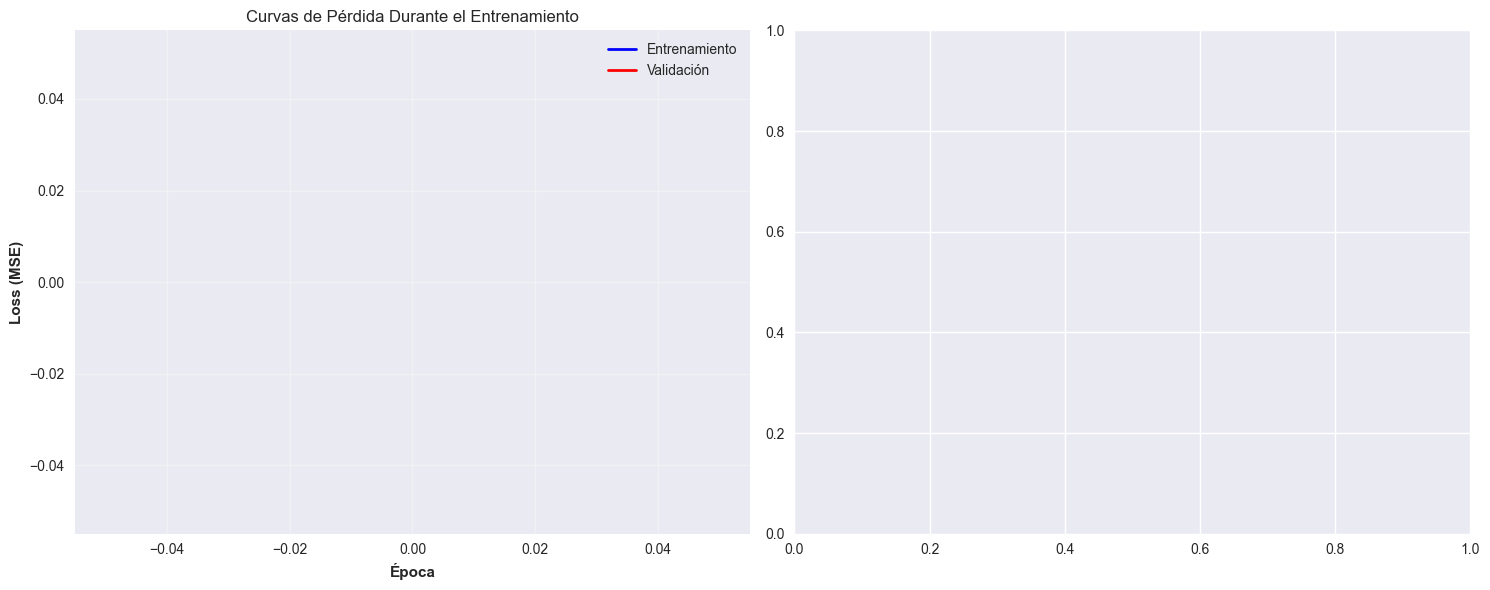

📈 ESTADÍSTICAS DE ENTRENAMIENTO:
  Mejor loss de entrenamiento: nan
  Mejor loss de validación: nan
  Épocas entrenadas: 16
  Overfitting (val/train ratio): nan

🎯 EVALUACIÓN DEL MODELO BASE


ValueError: Input contains NaN.

In [42]:
def prepare_rnn_data(processed_data, sequence_length=12):
    """
    Preparar datos para el modelo RNN
    """
    print("🔧 PREPARANDO DATOS PARA RNN")
    print("=" * 40)
    
    # Usar datos procesados
    df_processed = processed_data['df_train_processed']
    feature_cols = processed_data['features']
    
    # Filtrar características para evitar data leakage
    safe_features = [col for col in feature_cols if 'lag_' not in col or 'lag_1' not in col]
    
    print(f"Características seleccionadas: {len(safe_features)}")
    print(f"Longitud de secuencia: {sequence_length}")
    
    # Crear dataset
    dataset = DengueDataset(
        data=df_processed,
        sequence_length=sequence_length,
        target_col='dengue',
        feature_cols=safe_features
    )
    
    print(f"Total de secuencias creadas: {len(dataset)}")
    
    # División temporal para train/val
    # Usar 80% para entrenamiento, 20% para validación
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )
    
    # Crear data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    return train_loader, val_loader, len(safe_features)

def train_base_model():
    """
    Entrenar modelo RNN base con hiperparámetros iniciales
    """
    print("\n🚀 ENTRENAMIENTO DEL MODELO BASE")
    print("=" * 50)
    
    # Preparar datos
    train_loader, val_loader, input_size = prepare_rnn_data(processed_data)
    
    # Hiperparámetros del modelo base
    model_config = {
        'input_size': input_size,
        'hidden_size': 64,
        'num_layers': 2,
        'output_size': 1,
        'rnn_type': 'LSTM',
        'dropout': 0.2,
        'bidirectional': False
    }
    
    print("Configuración del modelo:")
    for key, value in model_config.items():
        print(f"  {key}: {value}")
    
    # Crear modelo
    model = DengueRNN(**model_config)
    
    print(f"\nPArámetros del modelo: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Entrenar modelo
    train_losses, val_losses = train_rnn_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100,
        learning_rate=0.001,
        patience=15
    )
    
    return model, train_losses, val_losses, train_loader, val_loader

def visualize_training_results(train_losses, val_losses):
    """
    Visualizar resultados del entrenamiento
    """
    print("\n📊 VISUALIZACIÓN DE RESULTADOS DE ENTRENAMIENTO")
    print("=" * 60)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Curvas de pérdida
    epochs = range(1, len(train_losses) + 1)
    axes[0].plot(epochs, train_losses, 'b-', label='Entrenamiento', linewidth=2)
    axes[0].plot(epochs, val_losses, 'r-', label='Validación', linewidth=2)
    axes[0].set_title('Curvas de Pérdida Durante el Entrenamiento')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Zoom en las últimas épocas para ver convergencia
    if len(train_losses) > 20:
        last_epochs = epochs[-20:]
        axes[1].plot(last_epochs, train_losses[-20:], 'b-', label='Entrenamiento', linewidth=2)
        axes[1].plot(last_epochs, val_losses[-20:], 'r-', label='Validación', linewidth=2)
        axes[1].set_title('Últimas 20 Épocas - Convergencia')
        axes[1].set_xlabel('Época')
        axes[1].set_ylabel('Loss (MSE)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de entrenamiento
    print("📈 ESTADÍSTICAS DE ENTRENAMIENTO:")
    print(f"  Mejor loss de entrenamiento: {min(train_losses):.4f}")
    print(f"  Mejor loss de validación: {min(val_losses):.4f}")
    print(f"  Épocas entrenadas: {len(train_losses)}")
    print(f"  Overfitting (val/train ratio): {min(val_losses)/min(train_losses):.2f}")

def evaluate_base_model(model, val_loader):
    """
    Evaluación del modelo base
    """
    print("\n🎯 EVALUACIÓN DEL MODELO BASE")
    print("=" * 40)
    
    # Realizar predicciones
    predictions = predict_with_rnn(model, val_loader)
    
    # Obtener targets reales
    actual_values = []
    model.eval()
    with torch.no_grad():
        for _, target in val_loader:
            actual_values.extend(target.numpy())
    
    actual_values = np.array(actual_values)
    
    # Calcular métricas
    mae_score = mean_absolute_error(actual_values, predictions)
    mse_score = mean_squared_error(actual_values, predictions)
    rmse_score = np.sqrt(mse_score)
    
    # MAPE (con manejo de ceros)
    mape_score = np.mean(np.abs((actual_values - predictions) / 
                               np.maximum(actual_values, 1e-8))) * 100
    
    print("📊 MÉTRICAS DE EVALUACIÓN:")
    print(f"  MAE (Mean Absolute Error): {mae_score:.4f}")
    print(f"  MSE (Mean Squared Error): {mse_score:.4f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse_score:.4f}")
    print(f"  MAPE (Mean Absolute Percentage Error): {mape_score:.2f}%")
    
    # Visualización de predicciones vs reales
    plt.figure(figsize=(12, 6))
    plt.scatter(actual_values, predictions, alpha=0.6, color='blue')
    plt.plot([actual_values.min(), actual_values.max()], 
             [actual_values.min(), actual_values.max()], 'r--', linewidth=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Predicciones vs Valores Reales - Modelo Base')
    plt.grid(True, alpha=0.3)
    
    # Añadir líneas de referencia
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Estadísticas en el gráfico
    correlation = np.corrcoef(actual_values, predictions)[0, 1]
    plt.text(0.05, 0.95, f'Correlación: {correlation:.3f}\nMAE: {mae_score:.3f}\nRMSE: {rmse_score:.3f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mae': mae_score,
        'mse': mse_score,
        'rmse': rmse_score,
        'mape': mape_score,
        'correlation': correlation,
        'predictions': predictions,
        'actual_values': actual_values
    }

# Ejecutar entrenamiento del modelo base
base_model, train_losses, val_losses, train_loader, val_loader = train_base_model()
visualize_training_results(train_losses, val_losses)
base_eval_results = evaluate_base_model(base_model, val_loader)